<a href="https://colab.research.google.com/github/mitul01/FER/blob/main/FER_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/colab-20210303T131708Z-001/colab

/content/drive/MyDrive/colab-20210303T131708Z-001/colab


In [2]:
from config import emotion_config as config
from pipeline.preprocessing import ImageToArrayPreprocessor
from pipeline.callbacks import EpochCheckpoint
from pipeline.callbacks import TrainingMonitor
from pipeline.io import HDF5DatasetGenerator
from pipeline.nn.conv import EmotionVGGNet
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model
from keras import backend as K
import argparse
import os

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [3]:
trainAug = ImageDataGenerator(rotation_range = 10, zoom_range = 0.1,
    horizontal_flip = True, rescale = 1 / 255.0, fill_mode = "nearest")

valAug = ImageDataGenerator(rescale = 1 / 255.0)
iap = ImageToArrayPreprocessor()

# initialize the training and validation dataset generators

trainGen = HDF5DatasetGenerator(config.TRAIN_HDF5, config.BATCH_SIZE,
    aug = trainAug, preprocessors = [iap], classes = config.NUM_CLASSES)
valGen = HDF5DatasetGenerator(config.VAL_HDF5, config.BATCH_SIZE,
    aug = valAug, preprocessors = [iap], classes = config.NUM_CLASSES)

/content/drive/My Drive/colab-20210303T131708Z-001/colab/pipeline/io/hdf5datasetgenerator.py:20: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.db = h5py.File(dbPath)


In [4]:
def build_net(optim):
    net = Sequential(name='FER_Net')

    #Block 1
    net.add(
        Conv2D(filters=64,kernel_size=(5,5),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_1')
    )
    net.add(BatchNormalization(name='batchnorm_1'))

    #Block 2
    net.add(
        Conv2D(filters=64,kernel_size=(5,5),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_3')
    )
    net.add(
        Conv2D(filters=64,kernel_size=(3,3),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_4')
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    # Pooling Block 1
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))

    # Block 3 
    net.add(
        Conv2D(filters=64,kernel_size=(5,5),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_5')
    )
    net.add(
        Conv2D(filters=64,kernel_size=(3,3),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_7')
    )
    net.add(BatchNormalization(name='batchnorm_3'))

    # Pooling Block 2 
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))

    # Block 4 
    net.add(
        Conv2D(filters=64,kernel_size=(5,5),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_9')
    )
    net.add(
        Conv2D(filters=64,kernel_size=(3,3),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_10')
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    net.add(
        Conv2D(filters=64,kernel_size=(5,5),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_11')
    )
    net.add(
        Conv2D(filters=64,kernel_size=(3,3),input_shape=(48,48,1),activation='relu',padding='same',name='conv2d_12')
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    
    # Pooling Block 3 
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))

    # Flatten Neural Net ( Dense Layers )
    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(128,activation='relu',name='dense_1')
    )
    net.add(Dropout(0.5, name='dropout_4'))
    net.add(BatchNormalization(name='batchnorm_6'))
    net.add(
        Dense(config.NUM_CLASSES,activation='softmax',name='out_layer')
      )
    net.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    
    net.summary()
    
    return net

In [5]:
batch_size = 32 #batch size of 32 performs the best.

epochs = 150
from tensorflow.keras import optimizers
optim=optimizers.Adam(0.001)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [6]:
model = build_net(optim) 

history=model.fit_generator(
    trainGen.generator(),
    steps_per_epoch = trainGen.numImages // batch_size,
    validation_data = valGen.generator(),
    validation_steps = valGen.numImages // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    verbose = 1
)

Model: "FER_Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        1024

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


897/897 [==============================] - 97s 70ms/step - loss: 1.7792 - accuracy: 0.3150 - val_loss: 1.2346 - val_accuracy: 0.5295
Epoch 2/150
897/897 [==============================] - 61s 68ms/step - loss: 1.1535 - accuracy: 0.5571 - val_loss: 1.0824 - val_accuracy: 0.5873
Epoch 3/150
897/897 [==============================] - 61s 68ms/step - loss: 1.0219 - accuracy: 0.6119 - val_loss: 1.0849 - val_accuracy: 0.5859
Epoch 4/150
897/897 [==============================] - 61s 68ms/step - loss: 0.9329 - accuracy: 0.6461 - val_loss: 1.0118 - val_accuracy: 0.6163
Epoch 5/150
897/897 [==============================] - 61s 68ms/step - loss: 0.8702 - accuracy: 0.6714 - val_loss: 1.0220 - val_accuracy: 0.6265
Epoch 6/150
897/897 [==============================] - 61s 68ms/step - loss: 0.8166 - accuracy: 0.6923 - val_loss: 0.9771 - val_accuracy: 0.6461
Epoch 7/150
897/897 [==============================] - 61s 68ms/step - loss: 0.7678 - accuracy: 0.7110 - val_loss: 1.0413 - val_accuracy: 0.63

In [7]:
testAug = ImageDataGenerator(rescale = 1 / 255.0)
iap = ImageToArrayPreprocessor()

testGen = HDF5DatasetGenerator(config.TEST_HDF5, config.BATCH_SIZE,
    aug = testAug, preprocessors = [iap], classes = config.NUM_CLASSES)

/content/drive/My Drive/colab-20210303T131708Z-001/colab/pipeline/io/hdf5datasetgenerator.py:20: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.db = h5py.File(dbPath)


In [8]:
predictions = model.predict_generator(testGen.generator(),steps=testGen.numImages //64, max_queue_size=64*2)

(loss, acc) = model.evaluate_generator(
	testGen.generator(),
	steps=testGen.numImages // config.BATCH_SIZE,
	max_queue_size=config.BATCH_SIZE * 2)
print("[INFO] accuracy: {:.2f}".format(acc * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 67.35


In [15]:
import matplotlib.pyplot as plt

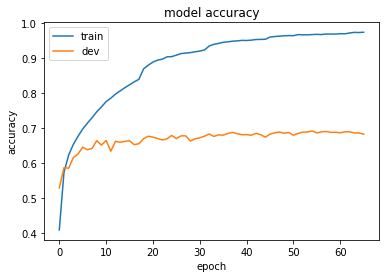

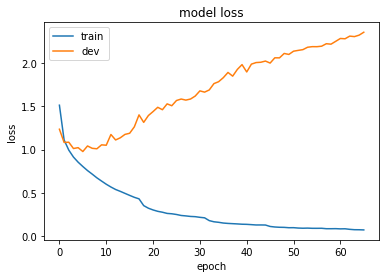

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()